#  Unsupervised learning addition model with generator

Author: S. Menary [sbmenary@gmail.com]

Date: 11/4/2023  (last update: 28/6/2023)

Overview: Train a `sequence -> sequence` model where the input sequence is a text representation of a simple sum $\sum_{i=1}^N A_i$ for a configurable number $N$ of integers $A_i\in\mathbb{Z}$, and the output is a set of logits representing the probability of each token in the output sequence. Integers may have a configurable number of digits. At inference time, chains of text are generated auto-regressively until the terminate-sequence token is reached. The loss function is a sparse categorical entropy.

The transformer is configurable. We support
- learnable skip connections
- learnable positional encodings
- multiple encoded outputs given equal weight in the loss function (to encourage convergence)
- repetition of encoder/decoder blocks in loops
- pre-loop layers allowing the transformer to process the input into an initial representation

---

## 1. Set up program

###  Import

All imports go here at the top of the notebook

In [1]:
##=========================##
##   All imports go here   ##
##=========================##

##  Import entire python stdlib packages
import logging, os, sys

##  Import entire pypi packages
import tensorflow as tf

##  Remove tensorflow INFO messages
tf.get_logger().setLevel('WARNING')

##  Add directory above this to system path to expose mathsformer package location
sys.path.append("/".join(os.getcwd().split("/")[:-1]))

##  Import individual modules/objects from local packages
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.optimizers import AdamW
from mathsformer import config, data, transformers, utils
from mathsformer import selfsupervised_learning_addition_model_backend as backend


## 1. Configure run

Set configuration variables for entire program

In [2]:
##==============================##
##   Set custom config values   ##
##==============================##

custom_config = {
    "global" : {
        "base_seed"        : -1,
        "working_dir"      : "SSL_loopy_enc_dec_notebook_[global>problem_tag]_embed[model>ndim_embedding]_enc_[model>encoder>num_blocks]blocks_[model>encoder>num_loops]loops_width[model>encoder>ndim_ff_hidden]_dec_[model>decoder>num_blocks]blocks_[model>decoder>num_loops]loops_width[model>decoder>ndim_ff_hidden]_post[model>post_decoder>num_layers]_width[model>post_decoder>ndim]_idem[model>idempotent_size]_[date]",
        "problem_tag"      : "int1235_num124578",
        "log_lvl_iostream" : logging.INFO,
        "log_lvl_fstream"  : logging.DEBUG,
    },
    "data" : {
        "train_data" : {
            "int_lengths"      : [1, 2],
            "num_ints"         : [1, 2, 4, 5],
            "batch_size"       : 32,
            "num_batches"      : 2000,
            "gen_base_seed"    : 101,
            "gen_reproducible" : False, 
        },
        "val_data" : {
            "int_lengths"      : [1, 2],
            "num_ints"         : [3, 6],
            "batch_size"       : 32,
            "num_batches"      : 40,
            "gen_base_seed"    : 102,
            "gen_reproducible" : True,
        },
        "test_data" : {
            "int_lengths"      : [1, 2],
            "num_ints"         : [7, 8, 9],
            "batch_size"       : 32,
            "num_batches"      : 100,
            "gen_base_seed"    : 103,
            "gen_reproducible" : True,
        },
        "characters"              : ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-'],
        "mask_char"               : 'M',
        "seq_start_char"          : 'B',
        "seq_end_char"            : 'E',
        "negative_char"           : 'N',
        "dtype"                   : "int32",
    },
    "model" : {
        "load_pretrained_model" : None,
        "name"                  : "mathsformer_LLM",
        "dtype"                 : "float32",
        "dropout"               : 0.1,
        "jit_compile"           : False,
        "use_old_loss"          : True,
        "optimizer"             : AdamW,
        "optimizer_args"        : {"learning_rate":1e-4, "weight_decay":2e-2},
        "idempotent_size"       : 3,
        "positional_encoding" : {
            "num_freqs"         : 32,
            "min_period"        : 4,
            "max_period"        : 200,
            "learnable"         : True,
        },
        "ndim_embedding"        : 64,
        "comb_type"             : 'mixture',
        "pre_encoder" : {
            "num_blocks"           : 2,
            "num_loops"            : 1,
            "num_heads"            : 8,
            "ndim"                 : 64,
            "ndim_att_hidden"      : 64,
            "ndim_ff_hidden"       : 128,
            "skip_connect"         : True,
            "mixture_skip_connect" : True,
        },
        "encoder" : {
            "num_blocks"           : 2,
            "num_loops"            : 6,
            "num_heads"            : 8,
            "ndim"                 : 64,
            "ndim_att_hidden"      : 64,
            "ndim_ff_hidden"       : 128,
            "skip_connect"         : True,
            "mixture_skip_connect" : True,
        },
        "decoder" : {
            "num_blocks"           : 2,
            "num_loops"            : 1,
            "num_heads"            : 8,
            "ndim"                 : 64,
            "ndim_att_hidden"      : 64,
            "ndim_ff_hidden"       : 128,
            "skip_connect"         : True,
            "mixture_skip_connect" : True,
        },
        "post_decoder" : {
            "num_layers"        : 2,
            "ndim"              : 128,
        },
    },
    "training" : {
        "train"          : True,
        "max_epochs"     : 100000,
        "log_after_epoch" : {
            "do"          : True,
            "log_lvl"     : logging.DEBUG,
        },
        "early_stopping" : {
            "do"                   : False,
            "patience"             : 6,
            "monitor"              : "loss",
            "mode"                 : "min",
            "restore_best_weights" : True,
        },
        "model_checkpoint" : {
            "do"       : True,
            "filename" : "model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.keras",
        },
        "layer_weights_record" : {
            "do"               : False,
            "batch_frequency"  : 2000,
            "recursive"        : True,
        },
        "adaptive_learning_rate" : {
            "do"                 : True,
            "decay_factor"       : 0.2,
            "monitor"            : "loss",
            "mode"               : "min",
            "patience"           : 2,
            "log_lvl"            : logging.DEBUG,
        },
        "print_tables_during_training" : {
            "do"        : True,
            "num_print" : 10,
        },
    },
    "evaluate" : {
        "num_print"            : 50,
        "save_model"           : True,
        "plot_weights"         : False,
        "plot_training_curves" : True,
    },
}


In [3]:
##===================================##
##   Load and validate full config   ##
##===================================##

##  Create config object containing default values
cfg = config.Config(backend.DEFAULT_CONFIG)

##  Override with custom values
cfg.load_dict(custom_config)

##  Validate config
backend.validate_config(cfg)

##  Print success
print(utils.fancy_message(f"Config created"))

##  For convenience, split configs for different sections
cfg_global   = cfg["global"  ]
cfg_data     = cfg["data"    ]
cfg_model    = cfg["model"   ]
cfg_training = cfg["training"]
cfg_evaluate = cfg["evaluate"]


===   Config created   ===


##  2. Set up environment

- Create working directory
- Create logger
- Log package versions for reproducibility
- Log config values for reproducibility
- Set random seeds for reproducibility


In [4]:
##==============================##
##   Create working directory   ##
##==============================##

##  Report success
working_dir, logger, base_seed, np_seed, tf_seed = utils.initialise_program(
    "unsupervised_learning_addition_model_generator (notebook)", 
    working_dir       = cfg_global["working_dir"], 
    cfg               = cfg,
    base_seed         = cfg_global["base_seed"],
    log_lvl_iostream  = cfg_global["log_lvl_iostream"],
    log_lvl_fstream   = cfg_global["log_lvl_fstream" ],
)


===   Working directory created at SSL_loopy_enc_dec_notebook_int1235_num124578_embed64_enc_2blocks_6loops_width128_dec_2blocks_1loops_width128_post2_width128_idem3_2023_06_28_v2   ===
   INFO initialise_logging: Begin logging on 2023-06-28 at 17:08:58
   INFO initialise_program: Program description: unsupervised_learning_addition_model_generator (notebook)
   INFO initialise_program: Working directory: SSL_loopy_enc_dec_notebook_int1235_num124578_embed64_enc_2blocks_6loops_width128_dec_2blocks_1loops_width128_post2_width128_idem3_2023_06_28_v2
   INFO log_versions: ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO log_versions:                                              PACKAGE  |  VERSION
   INFO log_versions: ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO log_versions:                     

   INFO log_versions:                                 platformdirs.version  |  3.6.0
   INFO log_versions:                                       prompt_toolkit  |  3.0.38
   INFO log_versions:                                               psutil  |  5.9.5
   INFO log_versions:                                           ptyprocess  |  0.7.0
   INFO log_versions:                                            pure_eval  |  0.2.2
   INFO log_versions:                                    pure_eval.version  |  0.2.2
   INFO log_versions:                                               pydevd  |  2.9.5
   INFO log_versions:                                             pygments  |  2.15.1
   INFO log_versions:                                            pyparsing  |  3.1.0
   INFO log_versions:                                                   re  |  2.2.1
   INFO log_versions:                                             requests  |  2.31.0
   INFO log_versions:                                 requests

   INFO initialise_program: Registered config value data > val_data > batch_size: 32
   INFO initialise_program: Registered config value data > val_data > num_batches: 40
   INFO initialise_program: Registered config value data > val_data > gen_base_seed: 102
   INFO initialise_program: Registered config value data > val_data > gen_reproducible: True
   INFO initialise_program: Registered config value data > test_data > int_lengths: [1, 2]
   INFO initialise_program: Registered config value data > test_data > num_ints: [7, 8, 9]
   INFO initialise_program: Registered config value data > test_data > batch_size: 32
   INFO initialise_program: Registered config value data > test_data > num_batches: 100
   INFO initialise_program: Registered config value data > test_data > gen_base_seed: 103
   INFO initialise_program: Registered config value data > test_data > gen_reproducible: True
   INFO initialise_program: Registered config value data > characters: ['M', 'B', 'E', 'N', '0', '1', '2', 

###  Report tensorflow devices


In [5]:
logger.info(f"Tensorflow with the following physical devices: {tf.config.list_physical_devices()}")

   INFO <module>: Tensorflow with the following physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


##  3. Create training data

###  Create tokeniser

Tokeniser object handles the transformation from strings to tensors and back again

In [6]:
##======================##
##   Create tokeniser   ##
##======================##

token_transform = data.TokenTransform.from_dictionary(cfg_data)
token_transform.summary(print_fn=logger.info)


   INFO summary: TokenTransform of dtype int32 with 16 characters: ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-']
   INFO summary: Special characters are seq_start_char (B), seq_end_char (E), mask_char (M)
   INFO summary: Tokeniser dictionary is {'M': 0, 'B': 1, 'E': 2, 'N': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '+': 14, '-': 15}
   INFO summary: Detokeniser dictionary is {0: 'M', 1: 'B', 2: 'E', 3: 'N', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '+', 15: '-'}


###  Create data generators for train/val/test sets

Data generators create tensor inputs/outputs for the model on-the-fly


In [7]:
##============================##
##   Create data generators   ##
##============================##

negative_char = cfg_data.get("negative_char")
train_gen, train_gen_reproducible, val_gen, test_gen = backend.get_data_generators(cfg_data, token_transform)


   INFO get_data_generators: Training data generator created with the following config: Generator of [1, 2, 4, 5] integers of length [1, 2] in 2000 batches of size 32 (base_seed=101, reproducible=False)
   INFO get_data_generators: Output shapes for a test batch are ((32, 19), (32, 5)), (32, 5)
   INFO get_data_generators: Validation data generator created with the following config: Generator of [3, 6] integers of length [1, 2] in 40 batches of size 32 (base_seed=102, reproducible=True)
   INFO get_data_generators: Output shapes for a test batch are ((32, 23), (32, 5)), (32, 5)
   INFO get_data_generators: Test data generator created with the following config: Generator of [7, 8, 9] integers of length [1, 2] in 100 batches of size 32 (base_seed=103, reproducible=True)
   INFO get_data_generators: Output shapes for a test batch are ((32, 31), (32, 5)), (32, 5)


###  Visualise training data

Plot the distribution of tokens in the training data, which helps us interpret the per-token accuracy in early training

   INFO plot_token_distribution: Saving distribution of token frequencies to file SSL_loopy_enc_dec_notebook_int1235_num124578_embed64_enc_2blocks_6loops_width128_dec_2blocks_1loops_width128_post2_width128_idem3_2023_06_28_v2/token_distribution.pdf


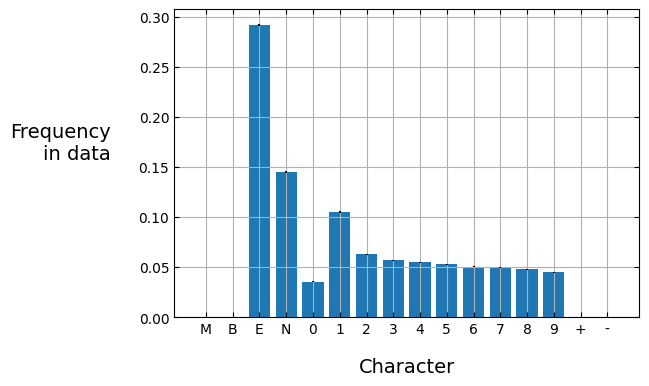

In [8]:
##=========================================================##
##   Quickly visualise distribution of token frequencies   ##
##=========================================================##

backend.plot_token_distribution(train_gen, savefig=f"{working_dir}/token_distribution.pdf")


##  4.  Create model

Create the keras model object that handles sequence-sequence transformations from alread-tokenised data

In [9]:
##===================================================##
##   Load or create self-supervised learning model   ##
##===================================================##

##  Get filename for load model
fname = cfg_model.get("load_pretrained_model", None)

##  Load model if fname is not None, otherwise create from scratch
if fname is not None :
    logger.info   (f"Loading model from: {fname}")
    logger.warning("Loading a pretrained model will disregard model config!")
    model = backend.load_text_to_text_model(fname)
    model.optimizer.learning_rate.assign(cfg_model["learning_rate"])  ## Reset LR to config value
else :
    logger.info(f"Creating new text-to-text model")
    model = backend.create_text_to_text_model_from_config(cfg_model, token_transform)

##  Create hack to catch model summary
model_summary = []
model.summary(print_fn = lambda s : model_summary.append(s))

##  Print model summary
logger.info("Model created with summary:")
for s in model_summary : logger.info(s)


   INFO <module>: Creating new text-to-text model


   INFO <module>: Model created with summary:


INFO:mathsformer:Model created with summary:


   INFO <module>: Model: "mathsformer_LLM"


INFO:mathsformer:Model: "mathsformer_LLM"


   INFO <module>: __________________________________________________________________________________________________


INFO:mathsformer:__________________________________________________________________________________________________


   INFO <module>:  Layer (type)                   Output Shape         Param #     Connected to                     


INFO:mathsformer: Layer (type)                   Output Shape         Param #     Connected to                     


   INFO <module>: ==================================================================================================


INFO:mathsformer:==================================================================================================


   INFO <module>:  mathsformer_LLM_encoder_input_  [(None, None)]      0           []                               


INFO:mathsformer: mathsformer_LLM_encoder_input_  [(None, None)]      0           []                               


   INFO <module>:  layer (InputLayer)                                                                               


INFO:mathsformer: layer (InputLayer)                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_enumer  (None, None)        0           ['mathsformer_LLM_encoder_input_l


INFO:mathsformer: mathsformer_LLM_encoder_enumer  (None, None)        0           ['mathsformer_LLM_encoder_input_l


   INFO <module>:  ate (Enumerate)                                                 ayer[0][0]']                     


INFO:mathsformer: ate (Enumerate)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_embedd  (None, None, 64)    1024        ['mathsformer_LLM_encoder_input_l


INFO:mathsformer: mathsformer_LLM_encoder_embedd  (None, None, 64)    1024        ['mathsformer_LLM_encoder_input_l


   INFO <module>:  ing (Embedding)                                                 ayer[0][0]']                     


INFO:mathsformer: ing (Embedding)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_positi  (None, None, 64)    32          ['mathsformer_LLM_encoder_enumera


INFO:mathsformer: mathsformer_LLM_encoder_positi  (None, None, 64)    32          ['mathsformer_LLM_encoder_enumera


   INFO <module>:  on_encoding (PositionalEncodin                                  te[0][0]']                       


INFO:mathsformer: on_encoding (PositionalEncodin                                  te[0][0]']                       


   INFO <module>:  g)                                                                                               


INFO:mathsformer: g)                                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_emb_an  (None, None, 64)    0           ['mathsformer_LLM_encoder_embeddi


INFO:mathsformer: mathsformer_LLM_encoder_emb_an  (None, None, 64)    0           ['mathsformer_LLM_encoder_embeddi


   INFO <module>:  d_pos (Average)                                                 ng[0][0]',                       


INFO:mathsformer: d_pos (Average)                                                 ng[0][0]',                       


   INFO <module>:                                                                   'mathsformer_LLM_encoder_positio


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_positio


   INFO <module>:                                                                  n_encoding[0][0]']               


INFO:mathsformer:                                                                 n_encoding[0][0]']               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_block_  (None, None, 64)    149508      ['mathsformer_LLM_encoder_emb_and


INFO:mathsformer: mathsformer_LLM_encoder_block_  (None, None, 64)    149508      ['mathsformer_LLM_encoder_emb_and


   INFO <module>:  1 (EncoderBlock)                                                _pos[0][0]',                     


INFO:mathsformer: 1 (EncoderBlock)                                                _pos[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [0][0]',                         


INFO:mathsformer:                                                                 [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [1][0]',                         


INFO:mathsformer:                                                                 [1][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [2][0]',                         


INFO:mathsformer:                                                                 [2][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [3][0]',                         


INFO:mathsformer:                                                                 [3][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [4][0]',                         


INFO:mathsformer:                                                                 [4][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [5][0]',                         


INFO:mathsformer:                                                                 [5][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [6][0]',                         


INFO:mathsformer:                                                                 [6][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [7][0]']                         


INFO:mathsformer:                                                                 [7][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_block_  (None, None, 64)    149508      ['mathsformer_LLM_encoder_block_1


INFO:mathsformer: mathsformer_LLM_encoder_block_  (None, None, 64)    149508      ['mathsformer_LLM_encoder_block_1


   INFO <module>:  2 (EncoderBlock)                                                [0][0]',                         


INFO:mathsformer: 2 (EncoderBlock)                                                [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [1][0]',                         


INFO:mathsformer:                                                                 [1][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [2][0]',                         


INFO:mathsformer:                                                                 [2][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [3][0]',                         


INFO:mathsformer:                                                                 [3][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [4][0]',                         


INFO:mathsformer:                                                                 [4][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [5][0]',                         


INFO:mathsformer:                                                                 [5][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [6][0]',                         


INFO:mathsformer:                                                                 [6][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [7][0]',                         


INFO:mathsformer:                                                                 [7][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [8][0]']                         


INFO:mathsformer:                                                                 [8][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_input_  [(None, None)]      0           []                               


INFO:mathsformer: mathsformer_LLM_decoder_input_  [(None, None)]      0           []                               


   INFO <module>:  layer (InputLayer)                                                                               


INFO:mathsformer: layer (InputLayer)                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_enumer  (None, None)        0           ['mathsformer_LLM_decoder_input_l


INFO:mathsformer: mathsformer_LLM_decoder_enumer  (None, None)        0           ['mathsformer_LLM_decoder_input_l


   INFO <module>:  ate (Enumerate)                                                 ayer[0][0]']                     


INFO:mathsformer: ate (Enumerate)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_embedd  (None, None, 64)    1024        ['mathsformer_LLM_decoder_input_l


INFO:mathsformer: mathsformer_LLM_decoder_embedd  (None, None, 64)    1024        ['mathsformer_LLM_decoder_input_l


   INFO <module>:  ing (Embedding)                                                 ayer[0][0]']                     


INFO:mathsformer: ing (Embedding)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_positi  (None, None, 64)    32          ['mathsformer_LLM_decoder_enumera


INFO:mathsformer: mathsformer_LLM_decoder_positi  (None, None, 64)    32          ['mathsformer_LLM_decoder_enumera


   INFO <module>:  on_encoding (PositionalEncodin                                  te[0][0]']                       


INFO:mathsformer: on_encoding (PositionalEncodin                                  te[0][0]']                       


   INFO <module>:  g)                                                                                               


INFO:mathsformer: g)                                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_emb_an  (None, None, 64)    0           ['mathsformer_LLM_decoder_embeddi


INFO:mathsformer: mathsformer_LLM_decoder_emb_an  (None, None, 64)    0           ['mathsformer_LLM_decoder_embeddi


   INFO <module>:  d_pos (Average)                                                 ng[0][0]',                       


INFO:mathsformer: d_pos (Average)                                                 ng[0][0]',                       


   INFO <module>:                                                                   'mathsformer_LLM_decoder_positio


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_positio


   INFO <module>:                                                                  n_encoding[0][0]']               


INFO:mathsformer:                                                                 n_encoding[0][0]']               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_block_  (None, None, 64)    282310      ['mathsformer_LLM_decoder_emb_and


INFO:mathsformer: mathsformer_LLM_decoder_block_  (None, None, 64)    282310      ['mathsformer_LLM_decoder_emb_and


   INFO <module>:  1 (DecoderBlock)                                                _pos[0][0]',                     


INFO:mathsformer: 1 (DecoderBlock)                                                _pos[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [5][0]',                         


INFO:mathsformer:                                                                 [5][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_emb_and


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_emb_and


   INFO <module>:                                                                  _pos[0][0]',                     


INFO:mathsformer:                                                                 _pos[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [6][0]',                         


INFO:mathsformer:                                                                 [6][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_emb_and


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_emb_and


   INFO <module>:                                                                  _pos[0][0]',                     


INFO:mathsformer:                                                                 _pos[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [7][0]',                         


INFO:mathsformer:                                                                 [7][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_emb_and


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_emb_and


   INFO <module>:                                                                  _pos[0][0]',                     


INFO:mathsformer:                                                                 _pos[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [8][0]']                         


INFO:mathsformer:                                                                 [8][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_block_  (None, None, 64)    282310      ['mathsformer_LLM_decoder_block_1


INFO:mathsformer: mathsformer_LLM_decoder_block_  (None, None, 64)    282310      ['mathsformer_LLM_decoder_block_1


   INFO <module>:  2 (DecoderBlock)                                                [0][0]',                         


INFO:mathsformer: 2 (DecoderBlock)                                                [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [5][0]',                         


INFO:mathsformer:                                                                 [5][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_block_1


   INFO <module>:                                                                  [1][0]',                         


INFO:mathsformer:                                                                 [1][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [6][0]',                         


INFO:mathsformer:                                                                 [6][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_block_1


   INFO <module>:                                                                  [2][0]',                         


INFO:mathsformer:                                                                 [2][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [7][0]',                         


INFO:mathsformer:                                                                 [7][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_block_1


   INFO <module>:                                                                  [3][0]',                         


INFO:mathsformer:                                                                 [3][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [8][0]']                         


INFO:mathsformer:                                                                 [8][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_output (FeedFo  (None, None, 16)    27024       ['mathsformer_LLM_decoder_block_2


INFO:mathsformer: mathsformer_LLM_output (FeedFo  (None, None, 16)    27024       ['mathsformer_LLM_decoder_block_2


   INFO <module>:  rwardBlock)                                                     [0][0]',                         


INFO:mathsformer: rwardBlock)                                                     [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_block_2


   INFO <module>:                                                                  [1][0]',                         


INFO:mathsformer:                                                                 [1][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_block_2


   INFO <module>:                                                                  [2][0]',                         


INFO:mathsformer:                                                                 [2][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_block_2


   INFO <module>:                                                                  [3][0]']                         


INFO:mathsformer:                                                                 [3][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>: ==================================================================================================


INFO:mathsformer:==================================================================================================


   INFO <module>: Total params: 892,772


INFO:mathsformer:Total params: 892,772


   INFO <module>: Trainable params: 892,772


INFO:mathsformer:Trainable params: 892,772


   INFO <module>: Non-trainable params: 0


INFO:mathsformer:Non-trainable params: 0


   INFO <module>: __________________________________________________________________________________________________


INFO:mathsformer:__________________________________________________________________________________________________


In [10]:
##==============================================================##
##   Create transformer wrapper for model and token_transform   ##
##==============================================================##

transformer = transformers.Transformer_Text_to_Text(model, token_transform)


In [11]:
##=========================================##
##   Test transformer on data generators   ##
##=========================================##

backend.test_transformer(transformer, train_gen, val_gen, test_gen, negative_char=negative_char)


   INFO test_transformer: Running text --> text mathsformer inference on some training data:


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:


   INFO print_predictions_table: -----------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:-----------------------------------------------------------------------------------


   INFO print_predictions_table:            INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


INFO:mathsformer.selfsupervised_learning_addition_model_backend:           INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


   INFO print_predictions_table: -----------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:-----------------------------------------------------------------------------------


   INFO print_predictions_table:    28+N3+6-N54-6           79        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:   28+N3+6-N54-6           79        99552 9955999999944B                      ?   


   INFO print_predictions_table:         1-1-25+1          N24        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:        1-1-25+1          N24        99552 9955999999944B                      ?   


   INFO print_predictions_table:    N88-N74-N8-N2           N4        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:   N88-N74-N8-N2           N4        99552 9955999999944B                      ?   


   INFO print_predictions_table:      N48+4+62-20           N2        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:     N48+4+62-20           N2        99552 9955999999944B                      ?   


   INFO print_predictions_table:        17-1-6+58           68        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:       17-1-6+58           68        99552 9955999999944B                      ?   


   INFO print_predictions_table:  2+N35+N82+1+N58         N172        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: 2+N35+N82+1+N58         N172        99552 9955999999944B                      ?   


   INFO print_predictions_table:           N10-78          N88        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:          N10-78          N88        99552 9955999999944B                      ?   


   INFO print_predictions_table:       N9-90-52-9         N160        99559 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:      N9-90-52-9         N160        99559 9955999999944B                      ?   


   INFO print_predictions_table:           N91+94            3        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:          N91+94            3        99552 9955999999944B                      ?   


   INFO print_predictions_table:      4+N4+75+N93          N18        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:     4+N4+75+N93          N18        99552 9955999999944B                      ?   


   INFO test_transformer: Running text --> text mathsformer inference on some validation data:


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some validation data:


   INFO print_predictions_table: ----------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:----------------------------------------------------------------------------------------


   INFO print_predictions_table:                 INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


   INFO print_predictions_table: ----------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:----------------------------------------------------------------------------------------


   INFO print_predictions_table:               N4-7-N6           N5        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:              N4-7-N6           N5        99552 9955999999944B                      ?   


   INFO print_predictions_table:  N1+N29-N70-N35+96-N4          175        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: N1+N29-N70-N35+96-N4          175        99552 9955999999944B                      ?   


   INFO print_predictions_table:              N5-N50-4           41        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:             N5-N50-4           41        99552 9955999999944B                      ?   


   INFO print_predictions_table:              N9+40+N9           22        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:             N9+40+N9           22        99552 9955999999944B                      ?   


   INFO print_predictions_table:              N68+6-N1          N61        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:             N68+6-N1          N61        99552 9955999999944B                      ?   


   INFO print_predictions_table:   N3+N89-94+N44+16+N2         N216        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  N3+N89-94+N44+16+N2         N216        99552 9955999999944B                      ?   


   INFO print_predictions_table:                8-N7-6            9        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:               8-N7-6            9        99552 9955999999944B                      ?   


   INFO print_predictions_table:     N28+N9+3+N4+1-N17          N20        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    N28+N9+3+N4+1-N17          N20        99552 9955999999944B                      ?   


   INFO print_predictions_table:     44+7-N50-N5-71+N6           29        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    44+7-N50-N5-71+N6           29        99552 9955999999944B                      ?   


   INFO print_predictions_table:             24+N5-N99          118        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:            24+N5-N99          118        99552 9955999999944B                      ?   


   INFO test_transformer: Running text --> text mathsformer inference on some test data:


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some test data:


   INFO print_predictions_table: ---------------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------------


   INFO print_predictions_table:                      INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                     INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


   INFO print_predictions_table: ---------------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------------------


   INFO print_predictions_table:   N45-N9+24-99-65-6-N16+N7         N173        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  N45-N9+24-99-65-6-N16+N7         N173        99552 9955999999944B                      ?   


   INFO print_predictions_table:     N79+43-8-N12-7+N75-9+4         N119        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    N79+43-8-N12-7+N75-9+4         N119        99552 9955999999944B                      ?   


   INFO print_predictions_table:     86-5-5+4-8+N5+17+N9-56           19        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    86-5-5+4-8+N5+17+N9-56           19        99552 9955999999944B                      ?   


   INFO print_predictions_table:   N9+N45-N9-N2+6+7-N42-N94          106        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  N9+N45-N9-N2+6+7-N42-N94          106        99552 9955999999944B                      ?   


   INFO print_predictions_table:      N67-37-N15+27-6+N8+N8          N84        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:     N67-37-N15+27-6+N8+N8          N84        99552 9955999999944B                      ?   


   INFO print_predictions_table:   3-N2+N4+N62-N17-1+N7+N78         N130        99559 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  3-N2+N4+N62-N17-1+N7+N78         N130        99559 9955999999944B                      ?   


   INFO print_predictions_table:        N4-43-N2+N9-7-N2-N5          N54        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:       N4-43-N2+N9-7-N2-N5          N54        99552 9955999999944B                      ?   


   INFO print_predictions_table:    N97-31+N75+62+N61+92-N1         N109        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:   N97-31+N75+62+N61+92-N1         N109        99552 9955999999944B                      ?   


   INFO print_predictions_table:       97+1+N65-N2+94+4-N93          226        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:      97+1+N65-N2+94+4-N93          226        99552 9955999999944B                      ?   


   INFO print_predictions_table:  N53+N18-N8+9+N1-N70+83-N4          102        99552 9955999999944B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: N53+N18-N8+9+N1-N70+83-N4          102        99552 9955999999944B                      ?   


##  5.  Train model

In [12]:
##===================================##
##   Create callbacks for training   ##
##===================================##

callbacks = backend.get_callbacks(cfg_training, working_dir, transformer=transformer, train_gen=train_gen_reproducible, 
                                  val_gen=val_gen, negative_char=negative_char)


   INFO get_callbacks: Registered training callback: LoggerCallback with loglvl=10


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: LoggerCallback with loglvl=10


   INFO get_callbacks: Registered training callback: AdaptiveLearningRate with decay_factor=0.2, patience=2, monitor=loss, mode=min, log_lvl=10


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: AdaptiveLearningRate with decay_factor=0.2, patience=2, monitor=loss, mode=min, log_lvl=10


   INFO get_callbacks: Registered training callback: ModelCheckpoint with filepath=SSL_loopy_enc_dec_notebook_int1235_num124578_embed64_enc_2blocks_6loops_width128_dec_2blocks_1loops_width128_post2_width128_idem3_2023_06_28_v2/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.keras


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: ModelCheckpoint with filepath=SSL_loopy_enc_dec_notebook_int1235_num124578_embed64_enc_2blocks_6loops_width128_dec_2blocks_1loops_width128_post2_width128_idem3_2023_06_28_v2/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.keras


   INFO get_callbacks: Registered training callback: LambdaCallback for test_transformer with num_print=10, negative_char='N'


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: LambdaCallback for test_transformer with num_print=10, negative_char='N'


In [ ]:
##=================##
##   Train model   ##
##=================##

do_train = cfg_training.get("train", True)

if do_train :
    max_epochs = cfg_training["max_epochs"]
    logger.info(f"Begin model training with max_epochs={max_epochs}")
    model.fit(train_gen, 
              epochs          = max_epochs,
              validation_data = val_gen,
              callbacks       = callbacks
             )
else :
    logger.warning("Skipping model training following global config instructions")


   INFO <module>: Begin model training with max_epochs=100000


INFO:mathsformer:Begin model training with max_epochs=100000
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Setting variable to learning_rate:0


Epoch 1/100000


2023-06-28 17:10:15.610582: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2000/2000 [==============================] - ETA: 0s - loss: 6.2925 - mathsformer_LLM_output_loss: 1.5736 - mathsformer_LLM_output_1_loss: 1.5721 - mathsformer_LLM_output_2_loss: 1.5723 - mathsformer_LLM_output_3_loss: 1.5745 - mathsformer_LLM_output_masked_categorical_accuracy: 0.4822 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4825 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4824 - mathsformer_LLM_output_3_masked_categorical_accuracy: 0.4820

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 0
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 6.2925
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.5736
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.5721
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.5723
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_3_loss: 1.5745
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.48216
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.48246
DEBUG:mathsformer.selfsupervised_learn

2000/2000 [==============================] - 449s 219ms/step - loss: 6.2925 - mathsformer_LLM_output_loss: 1.5736 - mathsformer_LLM_output_1_loss: 1.5721 - mathsformer_LLM_output_2_loss: 1.5723 - mathsformer_LLM_output_3_loss: 1.5745 - mathsformer_LLM_output_masked_categorical_accuracy: 0.4822 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4825 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4824 - mathsformer_LLM_output_3_masked_categorical_accuracy: 0.4820 - val_loss: 6.4517 - val_mathsformer_LLM_output_loss: 1.6085 - val_mathsformer_LLM_output_1_loss: 1.6113 - val_mathsformer_LLM_output_2_loss: 1.6147 - val_mathsformer_LLM_output_3_loss: 1.6172 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4722 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4684 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4690 - val_mathsformer_LLM_output_3_masked_categorical_accuracy: 0.4677
Epoch 2/100000
2000/2000 [==============================]

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 1
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 5.6755
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.42
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.4163
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.4174
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_3_loss: 1.4218
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.51159
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5126
DEBUG:mathsformer.selfsupervised_learning

2000/2000 [==============================] - 445s 223ms/step - loss: 5.6755 - mathsformer_LLM_output_loss: 1.4200 - mathsformer_LLM_output_1_loss: 1.4163 - mathsformer_LLM_output_2_loss: 1.4174 - mathsformer_LLM_output_3_loss: 1.4218 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5116 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5126 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5119 - mathsformer_LLM_output_3_masked_categorical_accuracy: 0.5101 - val_loss: 6.4764 - val_mathsformer_LLM_output_loss: 1.6197 - val_mathsformer_LLM_output_1_loss: 1.6188 - val_mathsformer_LLM_output_2_loss: 1.6182 - val_mathsformer_LLM_output_3_loss: 1.6197 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4671 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4671 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4671 - val_mathsformer_LLM_output_3_masked_categorical_accuracy: 0.4672
Epoch 3/100000
2000/2000 [==============================]

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 2
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 5.1133
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.2794
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.2744
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.2762
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_3_loss: 1.2834
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.56294
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.56334
DEBUG:mathsformer.selfsupervised_learn

2000/2000 [==============================] - 447s 223ms/step - loss: 5.1133 - mathsformer_LLM_output_loss: 1.2794 - mathsformer_LLM_output_1_loss: 1.2744 - mathsformer_LLM_output_2_loss: 1.2762 - mathsformer_LLM_output_3_loss: 1.2834 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5629 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5633 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5619 - mathsformer_LLM_output_3_masked_categorical_accuracy: 0.5594 - val_loss: 6.4862 - val_mathsformer_LLM_output_loss: 1.6221 - val_mathsformer_LLM_output_1_loss: 1.6178 - val_mathsformer_LLM_output_2_loss: 1.6205 - val_mathsformer_LLM_output_3_loss: 1.6258 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4715 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4726 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4718 - val_mathsformer_LLM_output_3_masked_categorical_accuracy: 0.4714
Epoch 4/100000
2000/2000 [==============================]

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 3
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 4.8041
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.2019
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.1959
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.199
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_3_loss: 1.2074
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.592
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.59274
DEBUG:mathsformer.selfsupervised_learning

2000/2000 [==============================] - 440s 220ms/step - loss: 4.8041 - mathsformer_LLM_output_loss: 1.2019 - mathsformer_LLM_output_1_loss: 1.1959 - mathsformer_LLM_output_2_loss: 1.1990 - mathsformer_LLM_output_3_loss: 1.2074 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5920 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5927 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5915 - mathsformer_LLM_output_3_masked_categorical_accuracy: 0.5883 - val_loss: 6.4315 - val_mathsformer_LLM_output_loss: 1.6209 - val_mathsformer_LLM_output_1_loss: 1.6069 - val_mathsformer_LLM_output_2_loss: 1.6007 - val_mathsformer_LLM_output_3_loss: 1.6030 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4727 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4727 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4721 - val_mathsformer_LLM_output_3_masked_categorical_accuracy: 0.4733
Epoch 5/100000
2000/2000 [==============================]

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 4
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 4.6277
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.1583
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.1522
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.1547
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_3_loss: 1.1626
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.60368
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.60454
DEBUG:mathsformer.selfsupervised_learn

2000/2000 [==============================] - 437s 218ms/step - loss: 4.6277 - mathsformer_LLM_output_loss: 1.1583 - mathsformer_LLM_output_1_loss: 1.1522 - mathsformer_LLM_output_2_loss: 1.1547 - mathsformer_LLM_output_3_loss: 1.1626 - mathsformer_LLM_output_masked_categorical_accuracy: 0.6037 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6045 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6030 - mathsformer_LLM_output_3_masked_categorical_accuracy: 0.6005 - val_loss: 6.9023 - val_mathsformer_LLM_output_loss: 1.7357 - val_mathsformer_LLM_output_1_loss: 1.7241 - val_mathsformer_LLM_output_2_loss: 1.7204 - val_mathsformer_LLM_output_3_loss: 1.7221 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4581 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4557 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4544 - val_mathsformer_LLM_output_3_masked_categorical_accuracy: 0.4520
Epoch 6/100000
2000/2000 [==============================]

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 5
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 4.5189
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.1321
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.1246
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.1268
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_3_loss: 1.1355
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.60969
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.61134
DEBUG:mathsformer.selfsupervised_learn

2000/2000 [==============================] - 442s 221ms/step - loss: 4.5189 - mathsformer_LLM_output_loss: 1.1321 - mathsformer_LLM_output_1_loss: 1.1246 - mathsformer_LLM_output_2_loss: 1.1268 - mathsformer_LLM_output_3_loss: 1.1355 - mathsformer_LLM_output_masked_categorical_accuracy: 0.6097 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6113 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6103 - mathsformer_LLM_output_3_masked_categorical_accuracy: 0.6077 - val_loss: 7.2092 - val_mathsformer_LLM_output_loss: 1.7740 - val_mathsformer_LLM_output_1_loss: 1.8045 - val_mathsformer_LLM_output_2_loss: 1.8154 - val_mathsformer_LLM_output_3_loss: 1.8153 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4553 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4499 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4471 - val_mathsformer_LLM_output_3_masked_categorical_accuracy: 0.4467
Epoch 7/100000
2000/2000 [==============================]

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 6
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 4.3868
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.0995
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.091
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.0934
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_3_loss: 1.1029
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.61952
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.62097
DEBUG:mathsformer.selfsupervised_learni

2000/2000 [==============================] - 441s 220ms/step - loss: 4.3868 - mathsformer_LLM_output_loss: 1.0995 - mathsformer_LLM_output_1_loss: 1.0910 - mathsformer_LLM_output_2_loss: 1.0934 - mathsformer_LLM_output_3_loss: 1.1029 - mathsformer_LLM_output_masked_categorical_accuracy: 0.6195 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6210 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6204 - mathsformer_LLM_output_3_masked_categorical_accuracy: 0.6170 - val_loss: 7.6611 - val_mathsformer_LLM_output_loss: 1.9227 - val_mathsformer_LLM_output_1_loss: 1.9259 - val_mathsformer_LLM_output_2_loss: 1.9118 - val_mathsformer_LLM_output_3_loss: 1.9007 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4605 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4599 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4610 - val_mathsformer_LLM_output_3_masked_categorical_accuracy: 0.4635
Epoch 8/100000
2000/2000 [==============================]

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 7
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 4.2832
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.0744
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.0655
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.0674
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_3_loss: 1.076
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.62527
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6273
DEBUG:mathsformer.selfsupervised_learnin

2000/2000 [==============================] - 443s 222ms/step - loss: 4.2832 - mathsformer_LLM_output_loss: 1.0744 - mathsformer_LLM_output_1_loss: 1.0655 - mathsformer_LLM_output_2_loss: 1.0674 - mathsformer_LLM_output_3_loss: 1.0760 - mathsformer_LLM_output_masked_categorical_accuracy: 0.6253 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6273 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6263 - mathsformer_LLM_output_3_masked_categorical_accuracy: 0.6236 - val_loss: 7.8356 - val_mathsformer_LLM_output_loss: 1.9666 - val_mathsformer_LLM_output_1_loss: 1.9713 - val_mathsformer_LLM_output_2_loss: 1.9534 - val_mathsformer_LLM_output_3_loss: 1.9443 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4586 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4579 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4594 - val_mathsformer_LLM_output_3_masked_categorical_accuracy: 0.4611
Epoch 9/100000
2000/2000 [==============================]

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 8
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 4.2115
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.0561
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.0479
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.0496
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_3_loss: 1.0579
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.63036
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.63259
DEBUG:mathsformer.selfsupervised_learn

2000/2000 [==============================] - 452s 226ms/step - loss: 4.2115 - mathsformer_LLM_output_loss: 1.0561 - mathsformer_LLM_output_1_loss: 1.0479 - mathsformer_LLM_output_2_loss: 1.0496 - mathsformer_LLM_output_3_loss: 1.0579 - mathsformer_LLM_output_masked_categorical_accuracy: 0.6304 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6326 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6322 - mathsformer_LLM_output_3_masked_categorical_accuracy: 0.6297 - val_loss: 6.8386 - val_mathsformer_LLM_output_loss: 1.7316 - val_mathsformer_LLM_output_1_loss: 1.7231 - val_mathsformer_LLM_output_2_loss: 1.7012 - val_mathsformer_LLM_output_3_loss: 1.6826 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4686 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4674 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4659 - val_mathsformer_LLM_output_3_masked_categorical_accuracy: 0.4637
Epoch 10/100000
 138/2000 [=>............................

In [ ]:
##================##
##   Save model   ##
##================##

do_save = cfg_evaluate.get("save_model", True)

if do_save :
    save_fname = f"{working_dir}/final_model.h5"
    model.save(save_fname)
    logger.info(f"Model saved to file {save_fname}")
else :
    logger.warning("Not saving model because no training was done")


## 6.  Evaluate model

In [ ]:
  
##  Find out how many datapoints to print predictions for 
num_print = cfg_evaluate.get("num_print", 20)

##  Print tables
backend.test_transformer(transformer, train_gen, val_gen, test_gen, num_print=num_print, 
                         negative_char=negative_char)


##  7. Additional visualisations

In [ ]:
##=============================================##
##   Visualise layer weights during training   ##
##=============================================##

if cfg_evaluate["plot_weights"] :
    
    logger.info("Plotting weights")
    backend.plot_weights(callbacks, show=True, close=True, savefig=f"{working_dir}/layer_weights.pdf")
    

In [ ]:

if cfg_evaluate["plot_training_curves"] :
    
    if not hasattr(model, "history") :
        logger.error("Cannot print training curves because no model history exists - perhaps you skipped training?")
    else :
        logger.info("Plotting training curves")
        backend.plot_training_curves(model.history.history, show=True, close=True, savefig=f"{working_dir}/training_curves.pdf")
    